In [1]:
import os, math, h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
from torch import Tensor
from tqdm import tqdm
from models import DriftModel, Interpolant
from utils import TrajectoryDataset, to_grid
from types import SimpleNamespace

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Config
WINDOW = 7  # must be >=2 (this decides cond channels)
CKPT_PATH = f"./checkpoints/latest_3hrly_window_{WINDOW}_cosine_normalized.best.pt"   # your trained weights
TRAIN_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_train.h5"
VAL_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_valid.h5"
USE_VAL = True  # True -> pick from VAL_H5, else TRAIN_H5
INDEX = 0   # which trajectory to demo
BETA_FN = "t^2"  # 't' or 't^2'
SIGMA_COEF = 1.0
EM_STEPS = 200
GUIDE = 0.1 # measurement guidance strength (0 disables)
NORMALIZE = False

# simulate sparse obs (mask target) for demo; replace with your real operator + y_obs if you have one
SIM_SPARSE_OBS = True
OBS_RATIO = 1.  # 25% pixels observed
OBS_NOISE_STD = 0.0

# scales
scalefact = 0.003061224412462883
train_mean = 0.0
train_std = 2672.231201171875
scale = scalefact * train_std

In [3]:
# Small helpers
def load_single_trajectory(h5_path: str, idx: int, window: int, normalize=False, mean=0.0, std=1.0) -> Tensor:
    """
    Return (1, T, C, H, W) cropped to window from dataset['x'] (N,T,C,H,W).
    """
    with h5py.File(h5_path, "r") as f:
        x = f["x"][idx]  # (T, C, H, W)
    T = x.shape[0]
    w = min(window, T)
    x = torch.from_numpy(x[:w]).float()  # (w,C,H,W)
    if normalize:
        x = (x - mean) / (std if std > 0 else 1.0)
    return x.unsqueeze(0)  # (1,w,C,H,W)

def build_cond_z0_z1(x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    """
    x: (B, T, C, H, W) with T>=2
    cond = x[:, :-1] flattened over time -> (B, (T-1)*C, H, W)
    z0   = x[:, -2]  (base/last past frame)
    z1   = x[:, -1]  (target frame; optional GT)
    """
    assert x.dim() == 5 and x.shape[1] >= 2
    B, T, C, H, W = x.shape
    past = x[:, :-1]                                 # (B, T-1, C, H, W)
    cond = past.reshape(B, (T-1)*C, H, W).contiguous()
    z0   = x[:, -2]                                  # (B, C, H, W)
    z1   = x[:, -1]                                  # (B, C, H, W)
    return cond, z0, z1

def make_mask_like(z: Tensor, ratio: float, seed: int = 0) -> Tensor:
    g = torch.Generator(device=z.device)
    g.manual_seed(seed)
    return (torch.rand(z.shape, generator=g, device=z.device) < ratio).float()

In [4]:
# Load one trajectory and build conditioning
h5_path = VAL_H5 if USE_VAL else TRAIN_H5
x = load_single_trajectory(h5_path, INDEX, WINDOW,
                           normalize=True, mean=train_mean, std=train_std
                          ).to(device)  # (1,T,C,H,W)
x *= scale
B, T, C, H, W = x.shape
print("shape:", (B, T, C, H, W))

cond, z0, z1 = build_cond_z0_z1(x)  # cond: (1,(T-1)*C,H,W), z0/z1: (1,C,H,W)
cond.shape, z0.shape, z1.shape

shape: (1, 7, 2, 64, 64)


(torch.Size([1, 12, 64, 64]),
 torch.Size([1, 2, 64, 64]),
 torch.Size([1, 2, 64, 64]))

In [5]:
h5_path = VAL_H5 if USE_VAL else TRAIN_H5
x = load_single_trajectory(h5_path, INDEX, 10,
                           normalize=True, mean=train_mean, std=train_std
                          ).to(device)  # (1,T,C,H,W)
x *= scale
B, T, C, H, W = x.shape
past = x[:, :6]                                 # (B, T-1, C, H, W)
cond = past.reshape(B, 6*C, H, W).contiguous()
z0   = x[:, 5]                                  # (B, C, H, W)
z1   = x[:, -1]                                  # (B, C, H, W)

In [6]:
# Load model
# data_cfg: only needs C for channel count
data_cfg = SimpleNamespace(C=C)

# model_cfg: must include all the attributes DriftModel expects
model_cfg = SimpleNamespace(
    unet_channels=64,
    unet_dim_mults=(1, 2, 2),
    unet_resnet_block_groups=8,
    unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64,
    unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True,
    unet_random_fourier_features=False,
    use_classes=False,
)

interp_cfg = SimpleNamespace(
    sigma_coef=1.0,
    beta_fn="t",
    t_min_train=0.0,
    t_max_train=1.0,
    t_min_sampling=0.0,
    t_max_sampling=0.999,
    EM_sample_steps=200
)

cond_channels = cond.shape[1]
drift = DriftModel(
    data_cfg=data_cfg,
    model_cfg=model_cfg,
    cond_channels=cond_channels
).to(device)
drift.eval()

# Load checkpoint: support both {"model": state_dict, ...} and raw state_dict
ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
drift.load_state_dict(state, strict=True)

interp = Interpolant(interp_cfg)

NOT USING CLASSES IN UNET


In [7]:
mask = make_mask_like(z1, ratio=OBS_RATIO, seed=0).to(device)
operator = lambda x: x * mask
y_obs = operator(z1)
if OBS_NOISE_STD > 0:
    y_obs = y_obs + OBS_NOISE_STD * mask * torch.randn_like(y_obs)

In [8]:
import math
import torch

@torch.no_grad()
def _sigma_broadcast(interp, tb, like: torch.Tensor):
    sig = interp.sigma(tb)
    # make broadcastable to (B,C,H,W)
    if sig.dim() == 1:
        sig = sig[:, None, None, None]
    return sig.expand_as(like) if sig.shape != like.shape else sig


def dps_x1_hat(drift, interp, x, t, cond, scale, device):
    tb = t.repeat(x.shape[0]).to(device)
    # denom = interp.beta(tb) * interp.alpha_dot(tb) - interp.alpha(tb) * interp.beta_dot(tb)
    # x1_hat = (scale * interp.beta(tb) * drift(x/scale, tb, cond=cond/scale) \
    #            - interp.beta_dot(tb) * x) / denom
    denom = interp.sigma(tb) * interp.beta_dot(tb) - interp.beta(tb) * interp.sigma_dot(tb)
    x1_hat = (interp.sigma(tb) * drift(x/scale, tb, cond=cond/scale) - interp.sigma_dot(tb) * x) / denom
    return x1_hat


def em_sample_conditioned(
    drift, interp,
    xt,            # (B,C,H,W) current state, will be *updated* and returned
    cond,          # (B,(T-1)C,H,W) conditioner
    y_obs,         # (B,C,H,W) observation at this step (normalized same as training)
    operator,      # differentiable measurement operator, e.g., lambda x: x * mask
    *,
    steps=200, t_min=0.0, t_max=0.999,
    guide=0.1, noise_scale=1.0,
    mc_samples=1, second_order=True,
    method='mc',
    verbose=False
):
    """
    One assimilation window: runs an EM-like sampler from t_min..t_max conditioned on y_obs.
    Returns the final xt (detached).
    """
    device = xt.device
    ts = torch.linspace(t_min, t_max, steps, device=device)
    dt = float(ts[1] - ts[0])

    # Freeze model params during sampling
    req = [p.requires_grad for p in drift.parameters()]
    for p in drift.parameters():
        p.requires_grad_(False)

    if verbose:
        pbar = tqdm(total=len(ts), desc="EM steps")
        
    for t in ts:
        xt = xt.detach().requires_grad_(True)
        tb = t.repeat(xt.shape[0]).to(device)

        # Drift and sigma (no grads through model params)
        with torch.no_grad():
            bF  = scale * drift(xt / scale, tb, cond=cond / scale)       # (B,C,H,W)
            sig = scale * _sigma_broadcast(interp, tb, like=xt)

        # ----- Monte Carlo look-aheads (expectation of measurement loss) -----
        if method == 'mc':
            losses = []
            for _ in range(mc_samples):
                eps_k  = torch.randn(xt.shape, device=device)
                # 1st order look-ahead to (approx) x_1
                x1_hat = xt + bF * (1.0 - t) + sig * eps_k * math.sqrt(max(1e-8, 1.0 - float(t)))
    
                if second_order:
                    with torch.no_grad():
                        t1  = torch.ones_like(tb)      # time ~ 1.0
                        bF2 = scale * drift(x1_hat / scale, t1, cond=cond / scale)
                    x1_hat = xt + 0.5*(bF + bF2)*(1.0 - t) + sig * eps_k * math.sqrt(max(1e-8, 1.0 - float(t)))
    
                meas = operator(x1_hat)               # same normalization as training!
                # losses.append((meas - y_obs).pow(2).mean())
                losses.append(torch.linalg.vector_norm(meas - y_obs, dim=(1,2,3)))
            loss_meas = torch.stack(losses).mean()
        elif method == 'dps':
            x1_hat = dps_x1_hat(drift, interp, xt, t, cond, scale, device)
            meas = operator(x1_hat)
            loss_meas = torch.linalg.vector_norm(meas - y_obs)
            
        grad_xt = torch.autograd.grad(loss_meas, xt, retain_graph=False, create_graph=False)[0]

        # EM update
        mu  = xt + bF * dt
        eps = torch.randn(mu.shape, device=device)
        xt  = mu + noise_scale * sig * eps * math.sqrt(dt) - guide * scale * grad_xt

        if verbose:
            pbar.update(1)
            pbar.set_postfix({"loss_meas": f"{float(loss_meas):.3f}"})
            
    # restore requires_grad flags
    for p, r in zip(drift.parameters(), req):
        p.requires_grad_(r)

    return xt.detach()


EM steps: 100%|██████████| 200/200 [00:11<00:00, 16.67it/s, loss_meas=4.298] 


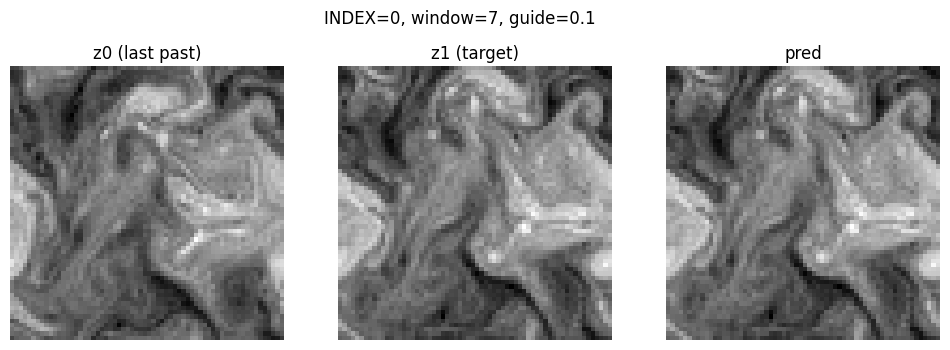

In [9]:
pred = em_sample_conditioned(
    drift=drift, interp=interp,
    xt=z0, cond=cond,
    y_obs=y_obs, operator=operator,
    steps=200, guide=1., mc_samples=5,
    noise_scale=0.2,
    verbose=True,
    method='dps'
)

# quick viz for C=1 or C=2
def show_triplet(z0, z1, pred, title=""):
    z0_ = z0[0].detach().cpu()
    z1_ = z1[0].detach().cpu()
    pr_ = pred[0].detach().cpu()

    nrow = 3
    fig, axes = plt.subplots(1, nrow, figsize=(12,4))
    def im(ax, img, ttl):
        img = img.squeeze(0) if img.dim()==3 and img.shape[0]==1 else img
        if img.dim()==3 and img.shape[0] in [1,3]:
            ax.imshow(img.permute(1,2,0), cmap=None if img.shape[0]==3 else "gray")
        else:
            ax.imshow(img[0], cmap="gray")
        ax.set_title(ttl); ax.axis("off")

    im(axes[0], z0_, "z0 (last past)")
    im(axes[1], z1_, "z1 (target)")
    im(axes[2], pr_, "pred")
    fig.suptitle(title); plt.show()

show_triplet(z0, z1, pred, title=f"INDEX={INDEX}, window={WINDOW}, guide={GUIDE}")

In [10]:
rmse = torch.mean((z1 - pred)**2)
print(f"rmse = {rmse:.3f}")

rmse = 0.002


In [11]:
# z0 = z0 + 0.1*torch.randn((5,)+z0.shape[1:], device=device)
# cond = cond + 0.1*torch.randn((5,)+cond.shape[1:], device=device)

preds = []
for i in range(4):
    pred = em_sample_conditioned_mc(
        drift=drift, interp=interp,
        xt=z0, cond=cond,
        y_obs=y_obs, operator=operator,
        steps=200, guide=0., mc_samples=1,
        noise_scale=1.
    )
    preds.append(pred)

preds = torch.cat(preds)

NameError: name 'em_sample_conditioned_mc' is not defined

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
mean_pred = preds.mean(dim=0)
for i in range(4):
    im0 = axs[0,i].imshow(preds[i,0].cpu())
    im1 = axs[1,i].imshow(torch.abs(preds[i]-mean_pred)[0].cpu())
    plt.colorbar(im0)
    plt.colorbar(im1)